In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##### Load model_df

In [69]:
model_df = pd.read_csv("../data/processed/model_clustered.csv")

#### Preprocessing

##### Encode Categorical Features

In [70]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [71]:
model_df.drop(["first_name", "last_name", "email", "phone", "customer_id", "signup_date", "last_trip_date", "payment_method", "device_type"], axis=1, inplace=True)

In [72]:
# Label encoding for binary categories
le = LabelEncoder()
model_df['gender'] = le.fit_transform(model_df['gender'])

# One-hot encoding for multi-class categorical variables
model_df = pd.get_dummies(model_df,
    columns=[
        "city",
        "income_level",
        "signup_channel",
        "persona"
    ],
    drop_first=True, dtype=int
)

###### Create correlation heatmap

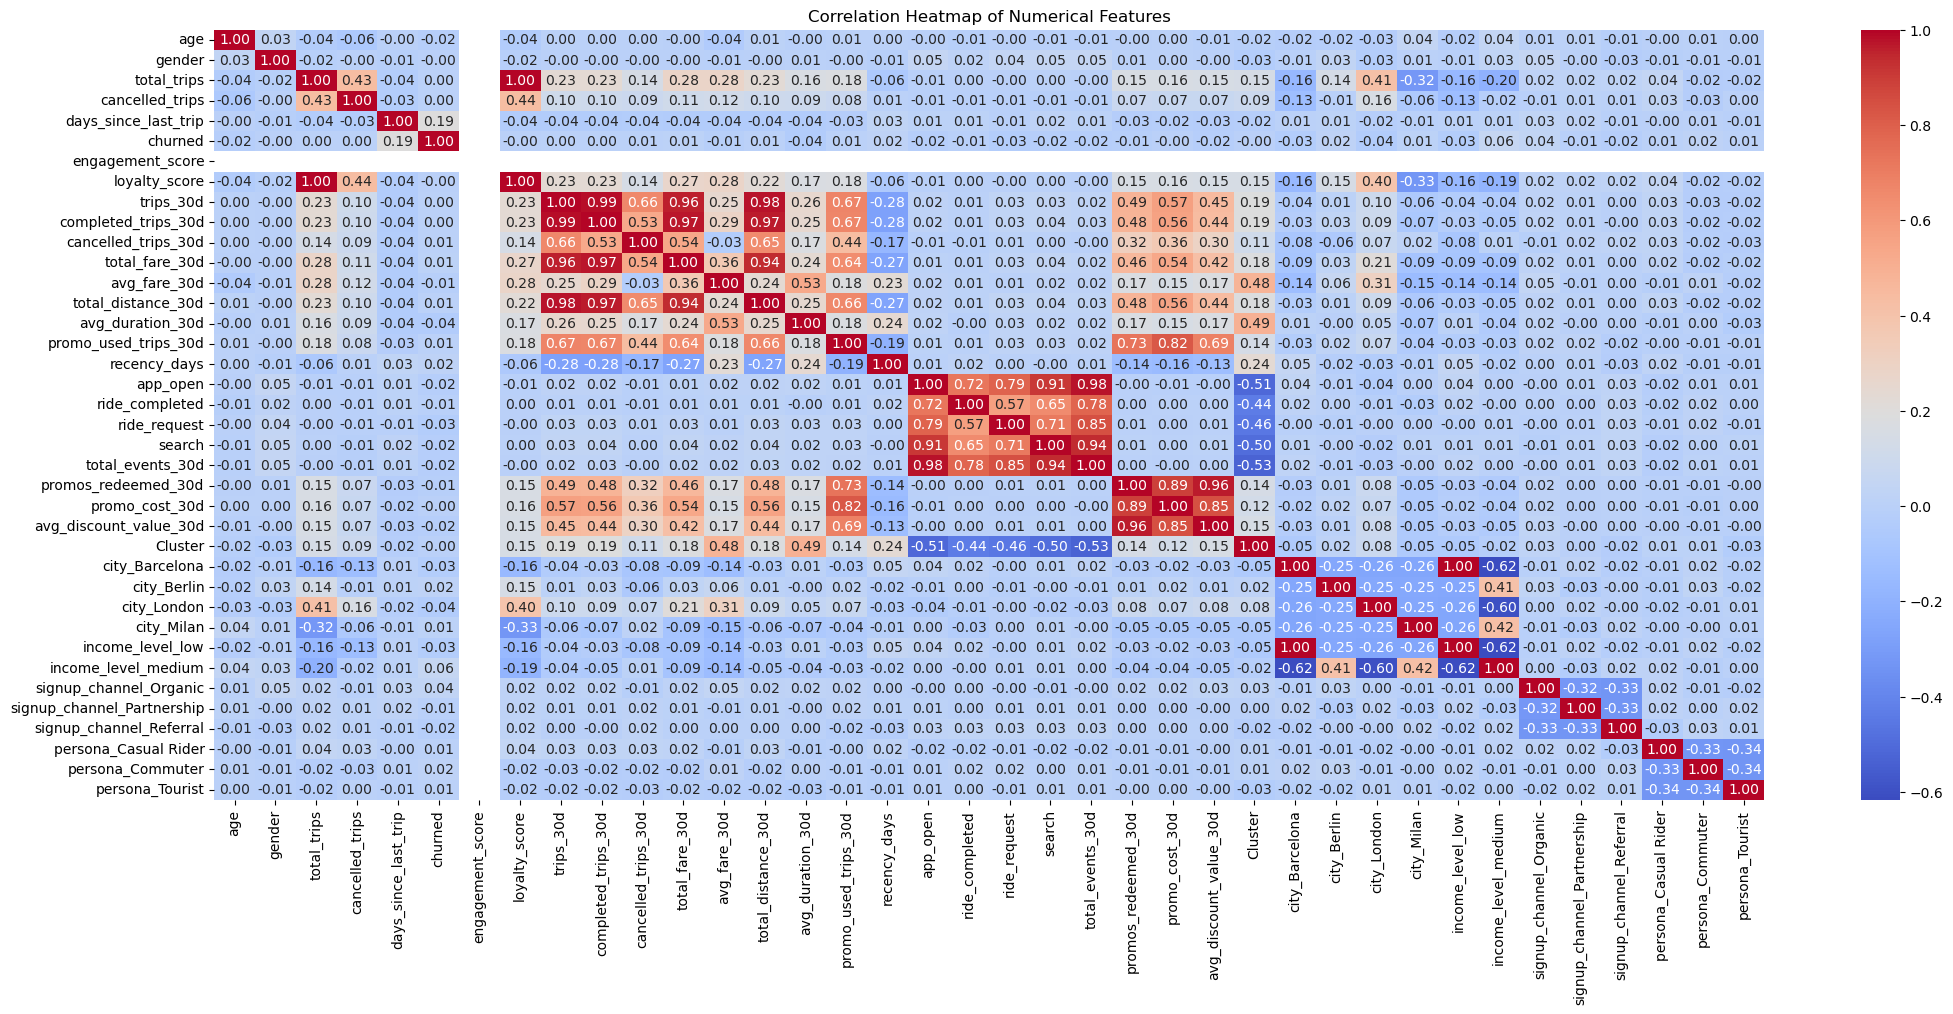

In [73]:
# Correlation matrix
corr_matrix = model_df.corr()

# Plot correlation heatmap

plt.figure(figsize=(25,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [74]:
model_df.shape

(3000, 38)

In [75]:
target_col = "churned"

# Select numeric features only
numeric_df = model_df.select_dtypes(include="number")

# Compute correlation with target
corr_with_target = (
    numeric_df
    .corr()[target_col]
    .drop(target_col)              # remove self-correlation
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={
        "index": "feature",
        target_col: "correlation"
    })
)

# View top correlated features
corr_with_target.head(38)


,feature,correlation
0,days_since_last_trip,0.193262
1,income_level_medium,0.056690
2,signup_channel_Organic,0.036218
3,city_Berlin,0.019753
4,persona_Commuter,0.019659
5,recency_days,0.017223
6,total_fare_30d,0.009610
7,city_Milan,0.009360
8,cancelled_trips_30d,0.008410
9,promo_used_trips_30d,0.006549


###### Drop irrelevant features

In [76]:
model_df.drop(['recency_days', 'cancelled_trips','engagement_score', 'loyalty_score',
       'promo_cost_30d','app_open', 'ride_completed',
       'ride_request', 'search', 'promos_redeemed_30d','avg_discount_value_30d', 'avg_fare_30d', 'avg_duration_30d'], axis=1, inplace=True)

In [77]:
model_df.shape

(3000, 25)

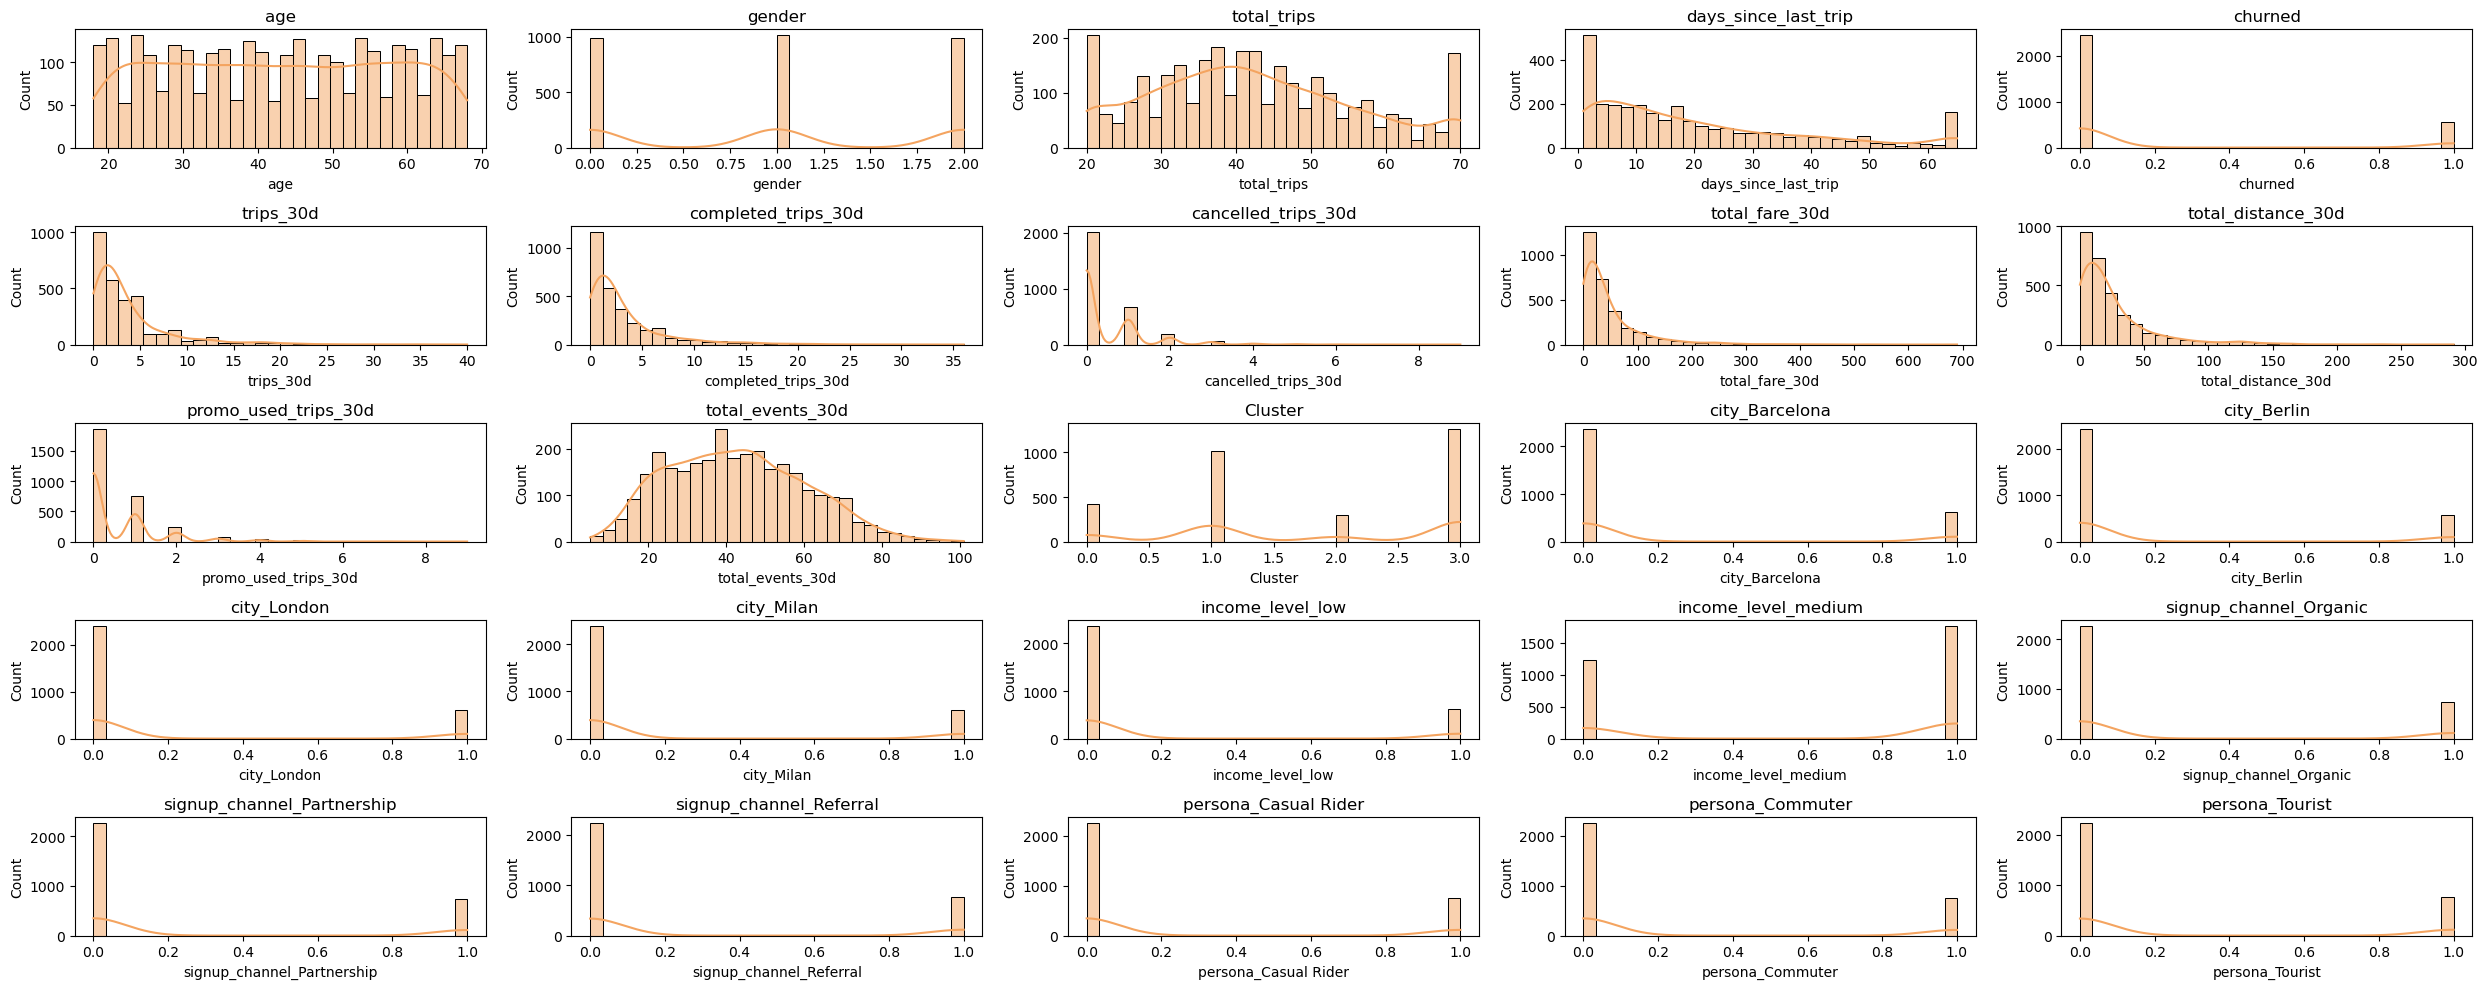

In [78]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(25, 10))
ax = ax.flatten()

for idx, col in enumerate(model_df):
    sns.histplot(model_df[col], ax=ax[idx], color="Sandybrown", bins=30, kde=True)
    ax[idx].set_title(col)

plt.tight_layout()
plt.show()

##### Scaling numerical features

In [79]:
from sklearn.preprocessing import RobustScaler

In [80]:
scaler = RobustScaler()
num_cols_to_scale = ['age', 'total_trips', 'days_since_last_trip',
       'churned', 'trips_30d','completed_trips_30d', 'cancelled_trips_30d', 'total_fare_30d',
       'total_distance_30d', 'promo_used_trips_30d', 'total_events_30d', 'Cluster']
model_df[num_cols_to_scale] = scaler.fit_transform(model_df[num_cols_to_scale])

###### check class distribution

In [81]:
model_df["churned"].value_counts()

churned
0.0    2451
1.0     549
Name: count, dtype: int64

In [82]:
model_df["churned"].value_counts(normalize=True)*100

churned
0.0    81.7
1.0    18.3
Name: proportion, dtype: float64

<Axes: xlabel='churned', ylabel='count'>

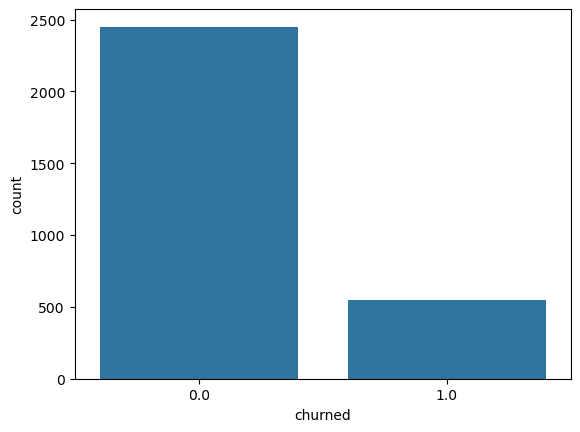

In [83]:
sns.countplot(x=model_df["churned"])

##### Handling Class Imbalance
###### Oversambling with SMOTE


In [84]:
from imblearn.over_sampling import SMOTE

# Seperate features and target
X = model_df.drop("churned", axis=1)
y = model_df["churned"]

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

y_resampled.value_counts()

churned
0.0    2451
1.0    2451
Name: count, dtype: int64

###### Convert the cleaned data back to dataframe

In [85]:
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df.head(3)

,age,gender,total_trips,days_since_last_trip,trips_30d,completed_trips_30d,cancelled_trips_30d,total_fare_30d,total_distance_30d,promo_used_trips_30d,...,city_London,city_Milan,income_level_low,income_level_medium,signup_channel_Organic,signup_channel_Partnership,signup_channel_Referral,persona_Casual Rider,persona_Commuter,persona_Tourist
0,-0.923077,2,1.157895,0.208333,0.25,0.333333,0.0,0.194435,1.363937e-16,0.0,...,1,0,0,0,0,0,0,0,0,1
1,0.692308,2,0.578947,1.208333,-0.50,-0.666667,0.0,-0.605708,-6.488147e-01,0.0,...,1,0,0,0,0,1,0,0,0,0
2,-0.461538,1,0.315789,-0.458333,0.50,0.333333,1.0,0.539812,5.117574e-01,1.0,...,1,0,0,0,0,0,0,0,0,0


In [86]:
resampled_df["churned"] = y_resampled
resampled_df.head(3)

,age,gender,total_trips,days_since_last_trip,trips_30d,completed_trips_30d,cancelled_trips_30d,total_fare_30d,total_distance_30d,promo_used_trips_30d,...,city_Milan,income_level_low,income_level_medium,signup_channel_Organic,signup_channel_Partnership,signup_channel_Referral,persona_Casual Rider,persona_Commuter,persona_Tourist,churned
0,-0.923077,2,1.157895,0.208333,0.25,0.333333,0.0,0.194435,1.363937e-16,0.0,...,0,0,0,0,0,0,0,0,1,0.0
1,0.692308,2,0.578947,1.208333,-0.50,-0.666667,0.0,-0.605708,-6.488147e-01,0.0,...,0,0,0,0,1,0,0,0,0,0.0
2,-0.461538,1,0.315789,-0.458333,0.50,0.333333,1.0,0.539812,5.117574e-01,1.0,...,0,0,0,0,0,0,0,0,0,0.0


###### save resampled data

In [87]:
resampled_df.to_csv('../data/processed/cleaned_churn_balanced.csv', index=False)

##### Data splitting

In [88]:
from sklearn.model_selection import train_test_split

# Split the dataset (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 3431
Testing set size: 1471


In [89]:
# Proportion of Train set distribution
y_train.value_counts(normalize=True)*100

churned
1.0    50.539201
0.0    49.460799
Name: proportion, dtype: float64

In [90]:
# Proportion of Test set distribution
y_test.value_counts(normalize=True)*100

churned
0.0    51.257648
1.0    48.742352
Name: proportion, dtype: float64

#### Model selection
##### Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score

In [92]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_probability = logreg.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probability)
f1 = f1_score(y_test, y_pred)

top_15 = int(0.15 * len(y_test))
top_idx = np.argsort(y_probability)[-top_15:]
precision_15 = precision_score(y_test.iloc[top_idx], np.ones(top_15))

print("Logistic Regression")
print(f"ROC-AUC: {auc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision@15%: {precision_15:.3f}")


Logistic Regression
ROC-AUC: 0.772
F1-score: 0.695
Precision@15%: 0.868


##### Insight
The Logistic Regression model shows limited ability to rank and identify churners, making it suitable only as a baseline and not reliable enough for precise or high-value retention targeting.

##### Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score

In [94]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_probability = rf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probability)
f1 = f1_score(y_test, y_pred)

top_15 = int(0.15 * len(y_test))
top_idx = np.argsort(y_probability)[-top_15:]
precision_15 = precision_score(y_test.iloc[top_idx], np.ones(top_15))

print("\nRandom Forest")
print(f"ROC-AUC: {auc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision@15%: {precision_15:.3f}")



Random Forest
ROC-AUC: 0.945
F1-score: 0.872
Precision@15%: 1.000


##### Insight
The Random Forest model demonstrates excellent predictive performance, with strong ranking ability (ROC-AUC 0.95) and highly effective churn targeting. All customers identified in the top 15% risk segment are true churners, making the model well-suited for cost-efficient retention strategies.

##### Xgboost

In [95]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score

In [96]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_probability = xgb.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probability)
f1 = f1_score(y_test, y_pred)

top_15 = int(0.15 * len(y_test))
top_idx = np.argsort(y_probability)[-top_15:]
precision_15 = precision_score(y_test.iloc[top_idx], np.ones(top_15))

print("\nXGBoost")
print(f"ROC-AUC: {auc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision@15%: {precision_15:.3f}")



XGBoost
ROC-AUC: 0.917
F1-score: 0.852
Precision@15%: 1.000


c:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:24:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##### Insight
The XGBoost model delivers excellent churn prediction performance, accurately ranking customers by risk and perfectly identifying churners within the top 15% highest-risk group, making it highly effective for targeted retention actions.

######